# Rotate antenna patterns with pycraf.geometry

## License

```
Rotate antenna patterns with pycraf.geometry
Copyright (C) 2016+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pycraf import conversions as cnv, antenna, geometry
from pycraf import antenna, geometry
from astropy import units as u

## IMT2020 (WRC-19 AI 1.13) composite patterns


For some of the compatibility studies related to WRC-19 Agenda Item 1.13, phased array antenna patterns are to be used. These patterns are provided in the pycraf.antenna subpackage (see also [pycraf Documentation](https://bwinkel.github.io/pycraf/latest/antenna/index.html#wrc-agenda-item-1-13-imt2020)). Phased-array antennas have multiple antenna elements, which can be used to form a beam into a certain direction, $(\alpha_i, \delta_i)$.

In [3]:
composite_kwargs_bs = {
    'G_Emax': 5 * cnv.dBi,
    'A_m': 30. * cnv.dB, 'SLA_nu': 30. * cnv.dB,
    'phi_3db': 65. * u.deg, 'theta_3db': 65. * u.deg,
    'd_H': 0.5 * cnv.dimless, 'd_V': 0.5 * cnv.dimless,
    'N_H': 8, 'N_V': 8,
}

composite_kwargs_ue = {
    'G_Emax': 5 * cnv.dBi,
    'A_m': 30. * cnv.dB, 'SLA_nu': 30. * cnv.dB,
    'phi_3db': 90. * u.deg, 'theta_3db': 90. * u.deg,
    'd_H': 0.5 * cnv.dimless, 'd_V': 0.5 * cnv.dimless,
    'N_H': 4, 'N_V': 4,
}

In [4]:
azims = np.arange(-180, 180, 1) * u.deg
elevs = np.arange(-90, 90, 1) * u.deg

azim_i, elev_i = 30 * u.deg, 20 * u.deg

gains_composite = antenna.imt2020_composite_pattern(
    azims[np.newaxis], elevs[:, np.newaxis],
    azim_i, elev_i,
    **composite_kwargs_bs,
    )
print('Gmax: {:.1f}'.format(gains_composite.max()))

Gmax: 19.6 dB


/media/scratch/bwinkel/miniconda3/envs/pycraf3.7/lib/python3.7/site-packages/pycraf-1.0.5.dev388-py3.7-linux-x86_64.egg/pycraf/antenna/imt.py:217: RuntimeWarning: divide by zero encountered in log10
  k=k,


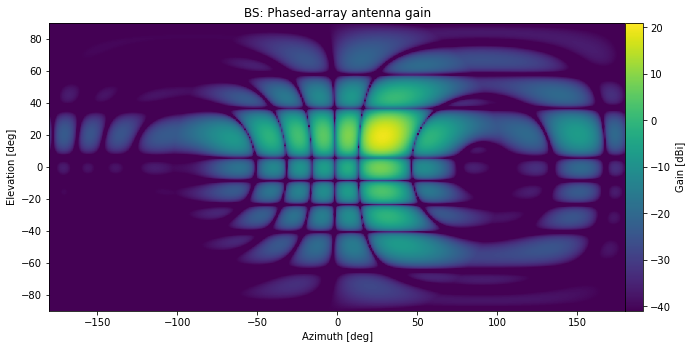

In [5]:
# avoid NaNs in plot
gains_composite[gains_composite < -100 * cnv.dBi] = -100 * cnv.dBi

plt.close()
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
cax = fig.add_axes((0.9, 0.1, 0.025, 0.8))
cim = ax.imshow(
    gains_composite.to(cnv.dBi).value,
    cmap='viridis', origin='lower', extent=(-180, 180, -90, 90),
    vmin=-41, vmax=21
    )
cbar = plt.colorbar(cim, cax=cax)
cbar.set_label('Gain [dBi]')
ax.set_aspect(1)
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Elevation [deg]')
ax.set_title('BS: Phased-array antenna gain')
plt.show()

## Tilted/rotated patterns

As can be seen, the formed beam points to a different direction than the antenna normal vector. However, the further the angular separation the more distorted the pattern becomes. Therefore, 5G basestation antennas will be mounted with a slight downtilt angle of about -10 degrees. This has benefits when most of the user equipment is located at a slightly negative elevation compared to the antenna center.

One could now simply calculate the beam pattern w.r.t. the tilted antenna frame using the above functions. However, often it is desired to get the pattern in the fixed (non-tilted) frame, because one needs to compute the effective antenna gain for a certain propagation path between Tx and Rx. (Likewise, one could modify/update the path geometry.)

Let's define a function that calculates the antenna pattern in the fixed frame that a tilted antenna would produce when a beam is formed to a certain direction.

In [6]:
def tilted_pattern_bs(tilt_angle, bs_height, ue_distance, ue_phi):
    '''
    Compute pattern of a tilted composite antenna in non-tilted frame.
    
    If 'ue_distance' and 'ue_phi' are vectors, calculate the average
    antenna pattern assuming all beams have the same weight.

    Parameters
    ----------
    tilt_angle : `~astropy.units.Quantity`
        Downtilt of BS antenna [deg]
        (Note: positive sign is downtilt, negative is uptilt)
    bs_height : `~astropy.units.Quantity`
        Height of antenna center above ground [m]
    ue_distance : `~astropy.units.Quantity`
        Distance of the UE from antenna base point [m]
    ue_phi : `~astropy.units.Quantity`
        Azimuth of the UE w.r.t. antenna base point [m]

    Returns
    -------
    Average gains : `~astropy.units.Quantity`
        Antenna pattern [dBi]
    '''
    
    az = np.arange(-180, 180., 1)
    el = np.arange(-90, 90., 1)
    azel_shape = np.broadcast(az[np.newaxis], el[:, np.newaxis]).shape

    # in the following we work with a "fixed" and a "tilted" BS frame
    # the latter is the one where the antenna pattern has to be calculated
    # in, while we want the average pattern to be in the fixed frame for
    # convenience

    # prepare rotation matrix to do the tilt (about y-axis)
    R = geometry.Ry(tilt_angle)
    Rinv = R.T  # inverse rotation matrix

    # first, we fill the BS cell with UEs (fixed frame)
    h = bs_height.to(u.m).value
    r = np.atleast_1d(ue_distance.to(u.m).value)
    phi = np.atleast_1d(ue_phi.to(u.deg).value)

    # calculate azim_i, elev_i, and distance in fixed frame
    azim_is = phi * u.deg
    elev_is = -np.degrees(np.arctan2(h, r)) * u.deg
    dist_is = np.sqrt(h ** 2 + r ** 2) * u.m

    # get the beam direction in the tilted frame; this is achieved
    # by inverse rotation of the fixed-frame beam vector
    x_is, y_is, z_is = geometry.sphere_to_cart(dist_is, azim_is, elev_is)
    # use numpy.einsum to perform the matrix multiplication over the 
    # proper indices
    x_is_tilt, y_is_tilt, z_is_tilt = np.einsum(
        'ij,j...->i...', Rinv, [x_is, y_is, z_is]
        ) * u.m  # unit is stripped by einsum, unfortunately
    dist_is_tilt, azim_is_tilt, elev_is_tilt = geometry.cart_to_sphere(
        x_is_tilt, y_is_tilt, z_is_tilt
        )

    # since we want the gains defined in the fixed BS frame (az, el), not
    # w.r.t. the tilted antenna plane frame, we apply the inverse rotation
    # matrix to the fixed-frame grid points (which gives us the location
    # of the grid points in the tilted frame)
    r_g, az_g, el_g = np.broadcast_arrays(1, az[np.newaxis], el[:, np.newaxis])
    r_g, az_g, el_g = r_g.flatten(), az_g.flatten(), el_g.flatten()
    x_g, y_g, z_g = geometry.sphere_to_cart(
        r_g * u.m, az_g * u.deg, el_g * u.deg
        )
    x_g_tilt, y_g_tilt, z_g_tilt = np.einsum(
        'ij,ju->iu', Rinv, [x_g, y_g, z_g]
        ) * u.m
    r_g_tilt, az_g_tilt, el_g_tilt = geometry.cart_to_sphere(
        x_g_tilt, y_g_tilt, z_g_tilt
        )

    # btw, make no mistake: the tilt won't make it so that the
    # maximum gain appears at the tilt-angle; the rotation
    # has impact on the other parts of the az/el plane though (distortion)
    gains = antenna.imt2020_composite_pattern(
        az_g_tilt[:, np.newaxis],
        el_g_tilt[:, np.newaxis],
        azim_is_tilt[np.newaxis],
        elev_is_tilt[np.newaxis],
        **composite_kwargs_bs,
        ).to(cnv.dimless).value

    avg_gains = (
        np.mean(gains, axis=1).reshape(azel_shape) * cnv.dimless
        ).to(cnv.dBi)
    
    return avg_gains


/media/scratch/bwinkel/miniconda3/envs/pycraf3.7/lib/python3.7/site-packages/astropy/units/function/logarithmic.py:46: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))


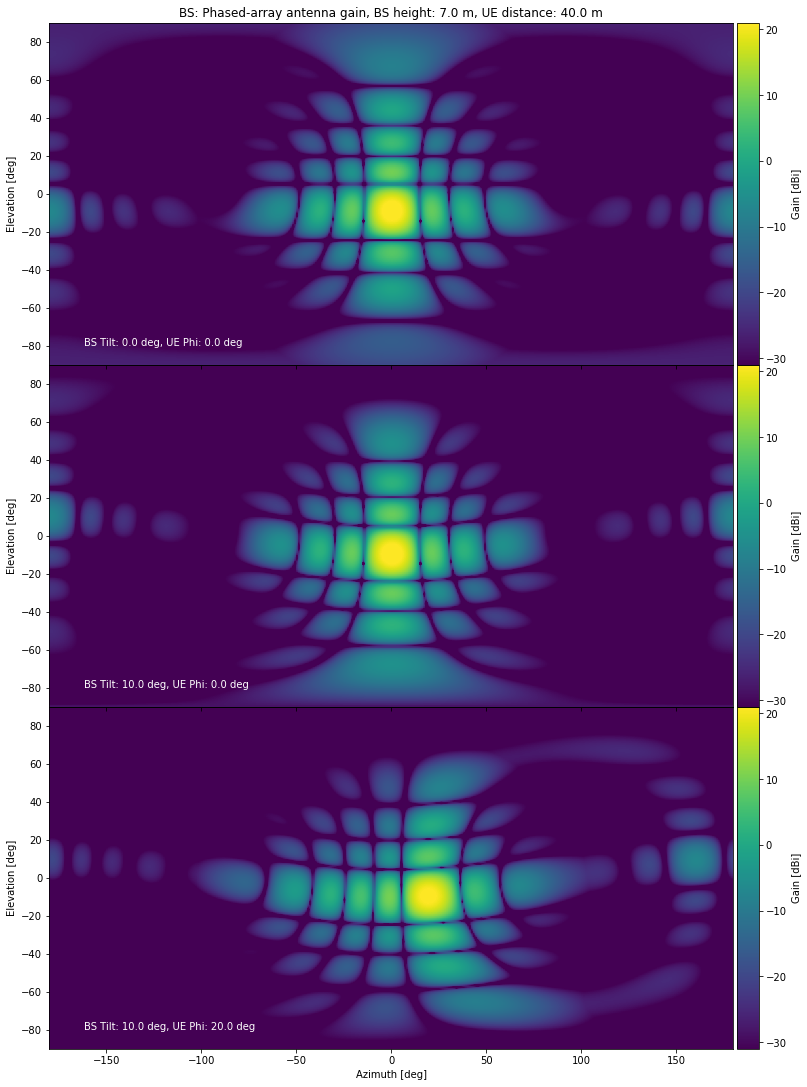

In [7]:
bs_height = 7 * u.m
ue_dist = 40 * u.m

plt.close()
fig = plt.figure(figsize=(12, 19))
axes = tuple(fig.add_axes((0.1, 0.1 + i * 0.25, 0.8, 0.25)) for i in range(3))
caxes = tuple(fig.add_axes((0.9, 0.1 + i * 0.25, 0.025, 0.25)) for i in range(3))

for ax, cax, tilt, ue_phi in zip(
        axes, caxes, [10, 10, 0] * u.deg, [20, 0, 0] * u.deg
        ):
    
    avg_gains = tilted_pattern_bs(
        tilt, bs_height, ue_dist, ue_phi
        )
    avg_gains[avg_gains < -100 * cnv.dBi] = -100 * cnv.dBi
    im = ax.imshow(
        avg_gains,
        cmap='viridis', origin='lower', extent=(-180, 180, -90, 90),
        vmin=-31, vmax=21
        )
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Gain [dBi]')
    ax.text(
        0.05, 0.05, 'BS Tilt: {:.1f}, UE Phi: {:.1f}'.format(tilt, ue_phi),
        va='bottom', ha='left', transform=ax.transAxes, color='w'
        )

    ax.set_xlim((-180, 180))
    ax.set_ylim((-90, 90))
    ax.set_aspect(1)
    ax.set_ylabel('Elevation [deg]')

axes[0].set_xlabel('Azimuth [deg]')
axes[1].set_xticklabels([])
axes[2].set_xticklabels([])
axes[2].set_title(
    'BS: Phased-array antenna gain, BS height: {:.1f}, '
    'UE distance: {:.1f}'.format(bs_height, ue_dist)
    )
plt.show()

The downtilt is clearly beneficial, as the pattern in the middle panel is much more symmetric than the pattern in the upper panel. Of course, if the UE is located further away from the antenna normal direction, the composite pattern gets less optimal (bottom panel).

For user equipment (UE) the situation is even more complex. The end users may hold their devices at more or less random rotation angle, such that the antenna frame normal vector can have large angular separations from the sight line to the BS. We follow a similar principle as above, to calculate the pattern, but use a general rotation matrix, instead of a simple rotation about the y-axis. Again, we introduce a fixed UE frame, which has exactly the orientation of the fixed BS frame, but with its origin at the UE (i.e., just translated). The rotated UE frame is obtained by applying the rotation matrix to the fixed UE frame.

The general rotation can be constructed from three Euler angles, e.g., following the 'zxz' scheme (see [geometry subpackage documentation](https://bwinkel.github.io/pycraf/geometry/index.html) for more details).

In [8]:
def rotated_pattern_ue(rot_angles, bs_height, ue_distance, ue_phi):
    '''
    Compute pattern of a freely rotated composite antenna in non-tilted frame.
    
    If 'ue_distance' and 'ue_phi' are vectors, calculate the average
    antenna pattern assuming all beams have the same weight.

    Parameters
    ----------
    rot_angles : `~astropy.units.Quantity`
        Euler angles (scheme 'zxz') of rotation [deg]
    bs_height : `~astropy.units.Quantity`
        Height of antenna center above ground [m]
    ue_distance : `~astropy.units.Quantity`
        Distance of the UE from antenna base point [m]
    ue_phi : `~astropy.units.Quantity`
        Azimuth of the UE w.r.t. antenna base point [m]

    Returns
    -------
    Average gains : `~astropy.units.Quantity`
        Antenna pattern [dBi]
    '''
    
    az = np.arange(-180, 180., 1)
    el = np.arange(-90, 90., 1)
    azel_shape = np.broadcast(az[np.newaxis], el[:, np.newaxis]).shape

    # in the following we work with a "fixed" and a "rotated" UE frame
    # the former frame has the same orientation as the BS frame and
    # is of course equal for all UE; the rotated frame is obtained
    # by rotating the UEs with a random angle

    # create rotation matrices that represent random UE orientation
    # note: 3-axis rotations are used, because this is the most general case
    a3, a2, a1 = rot_angles
    R = geometry.multiply_matrices(
        geometry.Rz(np.atleast_1d(a3)),
        geometry.Rx(np.atleast_1d(a2)),
        geometry.Rz(np.atleast_1d(a1)),
        )
    Rinv = np.array([r.T for r in R])

    # first, we want to know the az/el offset of the rotated UE frames
    # (we need this to compare with the az/el of the path to the BS)
    # we just rotate the x-axis for this
    # since we want to know the az/el position of the fixed UE frame
    # x-axis vector (having az/el=0/0 in the the fixed frame) in the
    # rotated frame, we have to apply the inverse rotation matrix
    ue_xs, ue_ys, ue_zs = np.einsum('uij,j->iu', Rinv, [1., 0., 0.]) * u.m
    ue_rs, ue_azs, ue_els = geometry.cart_to_sphere(ue_xs, ue_ys, ue_zs)

    # next, we randomly position UEs into a BS sector and calculate the
    # respective looking angles (in the fixed UE frame)

    r = np.array([ue_distance.to(u.m).value])
    phi = np.array([ue_phi.to(u.deg).value])
    h = bs_height.to(u.m).value

    azim_is = -phi * u.deg
    elev_is = np.degrees(np.arctan2(h, r)) * u.deg
    dist_is = np.sqrt(h ** 2 + r ** 2) * u.m

    # we now rotate the looking angles with the inverse R matrices;
    # this is effectively the same as calculating the az/el position
    # of the BS vector in the rotated frame
    x_is, y_is, z_is = geometry.sphere_to_cart(dist_is, azim_is, elev_is)
    x_is_rot, y_is_rot, z_is_rot = np.einsum(
        'uij,ju->iu', Rinv, [x_is, y_is, z_is]
        ) * u.m
    dist_is_rot, azim_is_rot, elev_is_rot = geometry.cart_to_sphere(
        x_is_rot, y_is_rot, z_is_rot
        )

    # finally, we calculate the antenna pattern in the rotated UE frames
    # and rotate this back to the fixed Az/El frame
    # to avoid gridding, we use a trick: we take the az/el grid points
    # in the fixed frame and calculate their az/el position in the
    # rotated frame by applying the inverse rotation matrix as before

    r_g, az_g, el_g = np.broadcast_arrays(1, az[np.newaxis], el[:, np.newaxis])
    r_g, az_g, el_g = r_g.flatten(), az_g.flatten(), el_g.flatten()
    x_g, y_g, z_g = geometry.sphere_to_cart(
        r_g * u.m, az_g * u.deg, el_g * u.deg
        )
    x_g_rot, y_g_rot, z_g_rot = np.einsum(
        'uij,jv->ivu', Rinv, [x_g, y_g, z_g]
        ) * u.m
    r_g_rot, az_g_rot, el_g_rot = geometry.cart_to_sphere(
        x_g_rot, y_g_rot, z_g_rot
        )

    all_gains = antenna.imt2020_composite_pattern(
        az_g_rot,
        el_g_rot,
        azim_is_rot[np.newaxis],
        elev_is_rot[np.newaxis],
        **composite_kwargs_ue
        ).to(cnv.dimless).value

    avg_gains = (
        np.mean(all_gains, axis=1).reshape(azel_shape) * cnv.dimless
        ).to(cnv.dBi) 

    return avg_gains

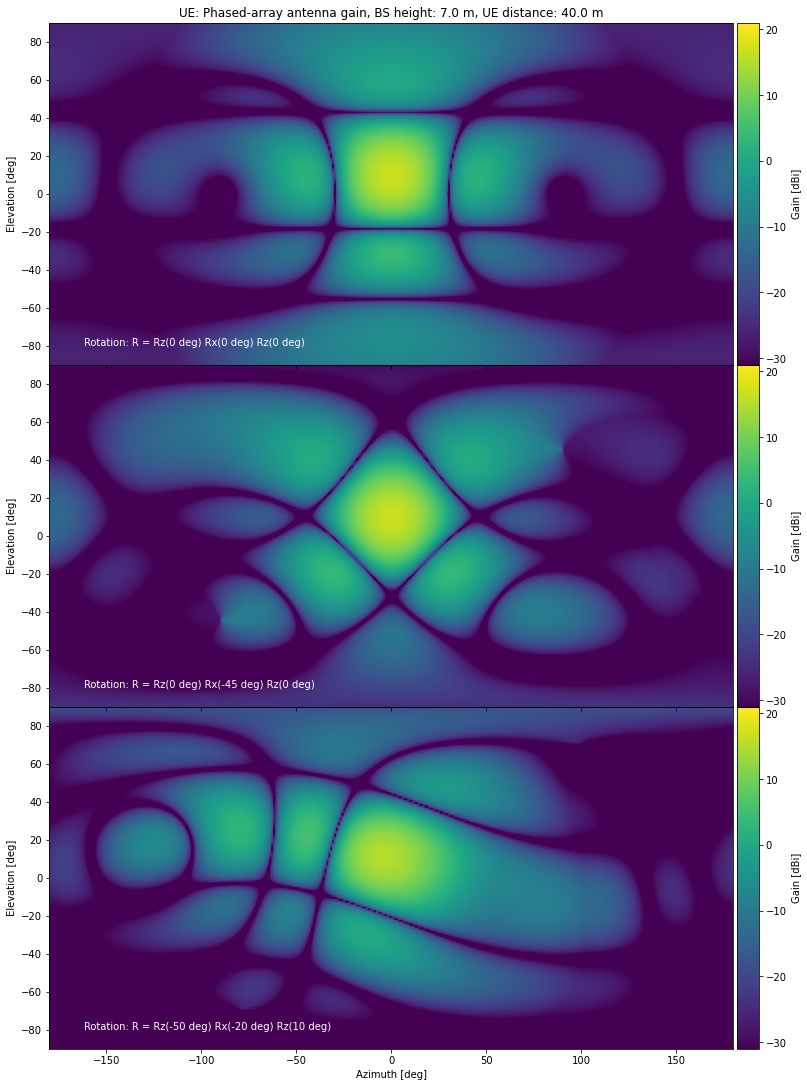

In [9]:
ue_dist = 40 * u.m
bs_height = 7 * u.m
ue_phi = 0 * u.deg

all_alphas = [
    [10, -20, -50],
    [0, -45, 0],
    [0, 0, 0],
    ] * u.deg

plt.close()
fig = plt.figure(figsize=(12, 19))
axes = tuple(fig.add_axes((0.1, 0.1 + i * 0.25, 0.8, 0.25)) for i in range(3))
caxes = tuple(fig.add_axes((0.9, 0.1 + i * 0.25, 0.025, 0.25)) for i in range(3))

for ax, cax, alphas in zip(axes, caxes, all_alphas):
    
    avg_gains = rotated_pattern_ue(alphas, bs_height, ue_dist, ue_phi)
    avg_gains[avg_gains < -100 * cnv.dBi] = -100 * cnv.dBi
    im = ax.imshow(
        avg_gains,
        cmap='viridis', origin='lower', extent=(-180, 180, -90, 90),
        vmin=-31, vmax=21
        )
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Gain [dBi]')
    ax.text(
        0.05, 0.05,
        'Rotation: R = Rz({:.0f}) Rx({:.0f}) Rz({:.0f})'.format(*alphas[::-1]),
        va='bottom', ha='left', transform=ax.transAxes, color='w'
        )

    ax.set_xlim((-180, 180))
    ax.set_ylim((-90, 90))
    ax.set_aspect(1)
    ax.set_ylabel('Elevation [deg]')

axes[0].set_xlabel('Azimuth [deg]')
axes[1].set_xticklabels([])
axes[2].set_xticklabels([])
axes[2].set_title(
    'UE: Phased-array antenna gain, BS height: {:.1f}, '
    'UE distance: {:.1f}'.format(bs_height, ue_dist)
    )
plt.show()

## Ensemble patterns

With the above we can now calculate effective (or ensemble) patterns for a case, where the position of the UE in the (120-deg) BS sector is not further specified. The idea is, that on UEs will be present following a certain azimuthal and distance distribution (w.r.t. the BS foot point) and by averaging we can calculate the expectation value of the antenna pattern.

We can utilize the functions from the previous section, but need to incorporate some restrictions and the distribution functions:

- UE distances shall follow a Rayleigh distribution, while the azimuths are Normal-distributed.
- A hard cut is applied to the azimuths to keep them in the 120-deg sector.
- For the UE, random orientations are allowed, but the resulting antenna plane normal vector should be separated by at most 60-deg from the line-of-sight to the BS.

In [10]:
ue_dists_distribution = stats.rayleigh(loc=0, scale=32)
ue_phis_distribution = stats.gennorm(beta=2, scale=np.sqrt(2) * 30)  # ~N(0, 30)

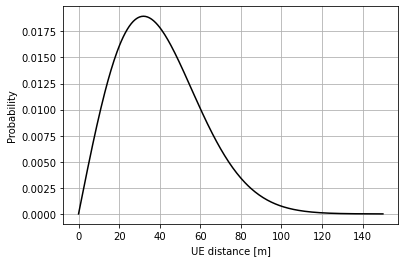

In [11]:
x = np.linspace(0, 150, 301)
y = ue_dists_distribution.pdf(x)

plt.plot(x, y, 'k-')
plt.xlabel('UE distance [m]')
plt.ylabel('Probability')
plt.grid()


In [12]:
def ensemble_pattern_bs(tilt_angle, bs_height, nsamples=10000):
    '''
    Compute ensemble pattern of a tilted composite antenna in non-tilted frame.
    
    Parameters
    ----------
    tilt_angle : `~astropy.units.Quantity`
        Downtilt of BS antenna [deg]
    bs_height : `~astropy.units.Quantity`
        Height of antenna center above ground [m]
    nsamples : int
        Number of random samples to use

    Returns
    -------
    Average gains : `~astropy.units.Quantity`
        Antenna pattern [dBi]
    '''
    
    az = np.arange(-180, 180., 1)
    el = np.arange(-90, 90., 1)
    azel_shape = np.broadcast(az[np.newaxis], el[:, np.newaxis]).shape

    # in the following we work with a "fixed" and a "tilted" BS frame
    # the latter is the one where the antenna pattern has to be calculated
    # in, while we want the average pattern to be in the fixed frame for
    # convenience

    R = geometry.Ry(tilt_angle)
    Rinv = R.T  # inverse rotation matrix

    # first, we fill the BS cell with UEs (fixed frame)
    h = bs_height.to(u.m).value
    r = ue_dists_distribution.rvs(size=nsamples)
    phi = ue_phis_distribution.rvs(size=nsamples)

    # apply restriction to 120-deg sector
    mask = (phi > -60) & (phi < 60)
    r, phi = r[mask], phi[mask]

    # calculate azim_i, elev_i, and distance in fixed frame
    azim_is = phi * u.deg
    elev_is = -np.degrees(np.arctan2(h, r)) * u.deg
    dist_is = np.hypot(h, r) * u.m

    # get the beam direction in the tilted frame; this is achieved
    # by inverse rotation of the fixed-frame beam vector
    x_is, y_is, z_is = geometry.sphere_to_cart(dist_is, azim_is, elev_is)
    # use numpy.einsum to perform the matrix multiplication over the 
    # proper indices
    x_is_tilt, y_is_tilt, z_is_tilt = np.einsum(
        'ij,j...->i...', Rinv, [x_is, y_is, z_is]
        ) * u.m  # unit is stripped, unfortunately
    dist_is_tilt, azim_is_tilt, elev_is_tilt = geometry.cart_to_sphere(
        x_is_tilt, y_is_tilt, z_is_tilt
        )

    # since we want the gains defined in the fixed BS frame (az, el), not
    # w.r.t. the tilted antenna plane frame, we apply the inverse rotation
    # matrix to the fixed-frame grid points (which gives us the location
    # of the grid points in the tilted frame)
    r_g, az_g, el_g = np.broadcast_arrays(1, az[np.newaxis], el[:, np.newaxis])
    r_g, az_g, el_g = r_g.flatten(), az_g.flatten(), el_g.flatten()
    x_g, y_g, z_g = geometry.sphere_to_cart(
        r_g * u.m, az_g * u.deg, el_g * u.deg
        )
    x_g_tilt, y_g_tilt, z_g_tilt = np.einsum(
        'ij,ju->iu', Rinv, [x_g, y_g, z_g]
        ) * u.m
    r_g_tilt, az_g_tilt, el_g_tilt = geometry.cart_to_sphere(
        x_g_tilt, y_g_tilt, z_g_tilt
        )

    # btw, make no mistake: the tilt won't make it so that the
    # maximum gain appears at the tilt-angle; the rotation
    # has impact on the other parts of the az/el plane though (distortion)
    gains = antenna.imt2020_composite_pattern(
        az_g_tilt[:, np.newaxis],
        el_g_tilt[:, np.newaxis],
        azim_is_tilt[np.newaxis],
        elev_is_tilt[np.newaxis],
        **composite_kwargs_bs,
        ).to(cnv.dimless).value

    avg_gains = (
        np.mean(gains, axis=1).reshape(azel_shape) * cnv.dimless
        ).to(cnv.dBi)
    
    return avg_gains, azim_is, elev_is, dist_is


In [13]:
bs_height = 7 * u.m
tilt_angle = 10 * u.deg

# the following is slow!
avg_gains, azim_is, elev_is, dist_is = ensemble_pattern_bs(
    tilt_angle, bs_height, nsamples=5000
    )

/media/scratch/bwinkel/miniconda3/envs/pycraf3.7/lib/python3.7/site-packages/pycraf-1.0.5.dev388-py3.7-linux-x86_64.egg/pycraf/antenna/imt.py:217: RuntimeWarning: divide by zero encountered in log10
  k=k,


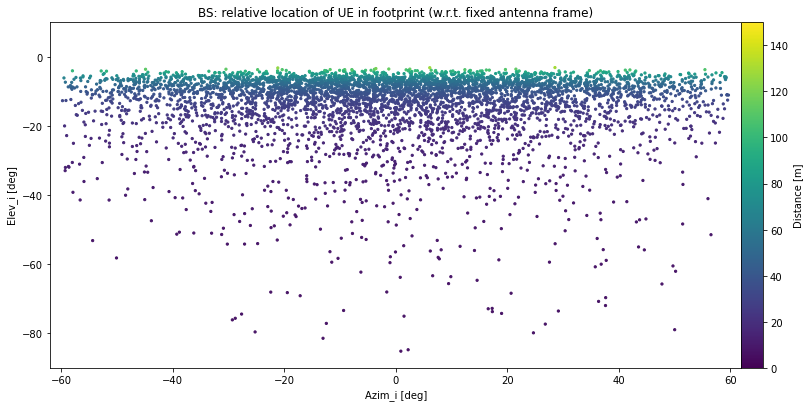

In [14]:
plt.close()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
cax = fig.add_axes((0.9, 0.1, 0.025, 0.8))
cim = ax.scatter(
    azim_is, elev_is, c=dist_is, s=5, cmap='viridis',
    vmin=0, vmax=150,
    )
cbar = plt.colorbar(cim, cax=cax)
cbar.set_label('Distance [m]')
ax.set_xlim((-62, 62))
ax.set_ylim((-90, 10))
ax.set_xlabel('Azim_i [deg]')
ax.set_ylabel('Elev_i [deg]')
ax.set_title(
    'BS: relative location of UE in footprint (w.r.t. fixed antenna frame)'
    )
plt.show()

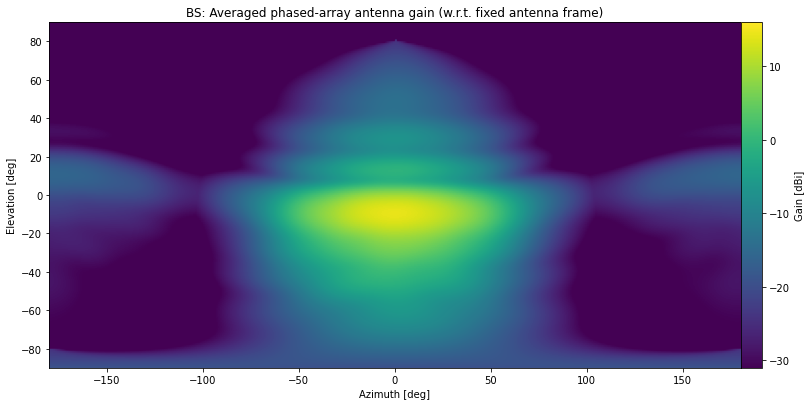

In [15]:
plt.close()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
cax = fig.add_axes((0.9, 0.1, 0.025, 0.8))
cim = ax.imshow(
    avg_gains,
    cmap='viridis', origin='lower', extent=(-180, 180, -90, 90),
    vmin=-31, vmax=16
    )
cbar = plt.colorbar(cim, cax=cax)
cbar.set_label('Gain [dBi]')
ax.set_xlim((-180, 180))
ax.set_ylim((-90, 90))
ax.set_aspect(1)
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Elevation [deg]')
ax.set_title(
    'BS: Averaged phased-array antenna gain (w.r.t. fixed antenna frame)'
    )
plt.show()

In [16]:
def ensemble_pattern_ue(bs_height, nsamples=10000):
    '''
    Compute ensemble UE pattern in non-tilted frame.
    
    Parameters
    ----------
    bs_height : `~astropy.units.Quantity`
        Height of antenna center above ground [m]
    nsamples : int
        Number of random samples to use

    Returns
    -------
    Average gains : `~astropy.units.Quantity`
        Antenna pattern [dBi]
    '''
    
    az = np.arange(-180, 180., 1)
    el = np.arange(-90, 90., 1)
    azel_shape = np.broadcast(az[np.newaxis], el[:, np.newaxis]).shape

    # create rotation matrices that represent random UE orientation
    # note: 3-axis rotations are used, because this is the most general case
    a3, a2, a1 = np.random.uniform(-np.pi, +np.pi, size=(3, nsamples))
    R = geometry.multiply_matrices(
        geometry.Rz(a3 * u.deg),
        geometry.Rx(a2 * u.deg),
        geometry.Rz(a1 * u.deg),
        )
    Rinv = np.array([r.T for r in R])

    # first, we want to know the az/el offset of the rotated UE frames
    # (we need this to compare with the az/el of the path to the BS)
    # we just rotate the x-axis for this
    # since we want to know the az/el position of the fixed UE frame
    # x-axis vector (having az/el=0/0 in the the fixed frame) in the
    # rotated frame, we have to apply the inverse rotation matrix
    ue_xs, ue_ys, ue_zs = np.einsum('uij,j->iu', Rinv, [1., 0., 0.]) * u.m
    ue_rs, ue_azs, ue_els = geometry.cart_to_sphere(ue_xs, ue_ys, ue_zs)

    # next, we randomly position UEs into a BS sector and calculate the
    # respective looking angles (in the fixed UE frame)
    h = bs_height.to(u.m).value
    r = ue_dists_distribution.rvs(size=nsamples)
    phi = ue_phis_distribution.rvs(size=nsamples)

    # apply restriction to 120-deg sector
    mask = (phi > -60) & (phi < 60)
    r, phi = r[mask], phi[mask]
    ue_rs, ue_azs, ue_els = ue_rs[mask], ue_azs[mask], ue_els[mask]
    R = R[mask]
    Rinv = Rinv[mask]

    azim_is = -phi * u.deg
    elev_is = np.degrees(np.arctan2(h, r)) * u.deg
    dist_is = np.sqrt(h ** 2 + r ** 2) * u.m

    off_angle = geometry.true_angular_distance(
        ue_azs, ue_els, azim_is, elev_is
        ).to(u.deg).value
    mask = off_angle < 60

    azim_is, elev_is, dist_is = azim_is[mask], elev_is[mask], dist_is[mask]
    ue_rs, ue_azs, ue_els = ue_rs[mask], ue_azs[mask], ue_els[mask]
    R = R[mask]
    Rinv = Rinv[mask]

    # we now rotate the looking angles with the inverse R matrices;
    # this is effectively the same as calculating the az/el position
    # of the BS vector in the rotated frame
    x_is, y_is, z_is = geometry.sphere_to_cart(dist_is, azim_is, elev_is)
    x_is_rot, y_is_rot, z_is_rot = np.einsum(
        'uij,ju->iu', Rinv, [x_is, y_is, z_is]
        ) * u.m
    dist_is_rot, azim_is_rot, elev_is_rot = geometry.cart_to_sphere(
        x_is_rot, y_is_rot, z_is_rot
        )

    # finally, we calculate the antenna pattern in the rotated UE frames
    # and rotate this back to the fixed Az/El frame
    # to avoid gridding, we use a trick: we take the az/el grid points
    # in the fixed frame and calculate their az/el position in the
    # rotated frame by applying the inverse rotation matrix as before

    r_g, az_g, el_g = np.broadcast_arrays(1, az[np.newaxis], el[:, np.newaxis])
    r_g, az_g, el_g = r_g.flatten(), az_g.flatten(), el_g.flatten()
    x_g, y_g, z_g = geometry.sphere_to_cart(
        r_g * u.m, az_g * u.deg, el_g * u.deg
        )
    x_g_rot, y_g_rot, z_g_rot = np.einsum(
        'uij,jv->ivu', Rinv, [x_g, y_g, z_g]
        ) * u.m
    r_g_rot, az_g_rot, el_g_rot = geometry.cart_to_sphere(
        x_g_rot, y_g_rot, z_g_rot
        )

    all_gains = antenna.imt2020_composite_pattern(
        az_g_rot,
        el_g_rot,
        azim_is_rot[np.newaxis],
        elev_is_rot[np.newaxis],
        **composite_kwargs_ue
        ).to(cnv.dimless).value

    avg_gains = (
        np.mean(all_gains, axis=1).reshape(azel_shape) * cnv.dimless
        ).to(cnv.dBi) 

    return avg_gains

In [17]:
bs_height = 7 * u.m

# the following is slow!
avg_gains = ensemble_pattern_ue(bs_height, nsamples=5000)

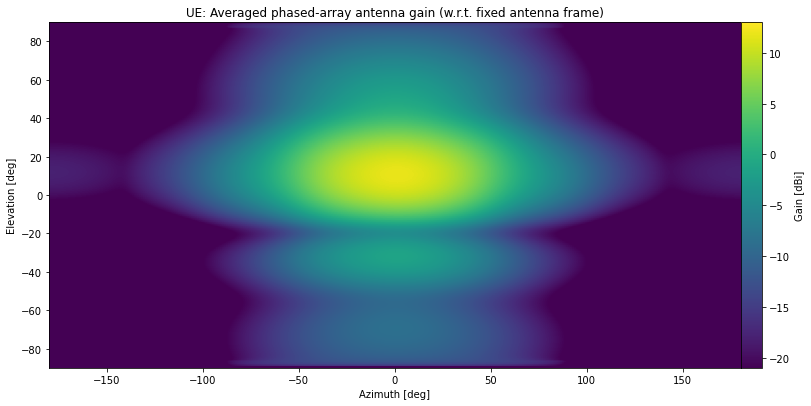

In [18]:
plt.close()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
cax = fig.add_axes((0.9, 0.1, 0.025, 0.8))
cim = ax.imshow(
    avg_gains,
    cmap='viridis', origin='lower', extent=(-180, 180, -90, 90),
    vmin=-21, vmax=13
    )
cbar = plt.colorbar(cim, cax=cax)
cbar.set_label('Gain [dBi]')
ax.set_xlim((-180, 180))
ax.set_ylim((-90, 90))
ax.set_aspect(1)
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Elevation [deg]')
ax.set_title(
    'UE: Averaged phased-array antenna gain (w.r.t. fixed antenna frame)'
    )
plt.show()

Note, that this looks quite different from the [single-element pattern](https://bwinkel.github.io/pycraf/latest/antenna/index.html#wrc-agenda-item-1-13-imt2020).